In [59]:
import numpy as np
import matplotlib.pyplot as plt

def initial_lattice(N):   
    # generates a random spin configuration for NxN lattice
    return 2*np.random.randint(2, size=(N,N))-1

# Compute energy of the lattice
def Hamiltonian(S, J, B):
    N = len(S[1])
    H = 0
    for i in range(N):
        for j in range(N):
            # Periodic boundary conditions (neighbors: right, down)
            H += -J * S[i][j] * (S[i][(j+1)%N] +  S[(i+1)%N][j]) - B * S[i][j]
    return H


def metropolis_step(S, J, B, beta, step_size_factor):
    N = len(S[1])
    for _ in range(N*N*step_size_factor): 
        i, j = np.random.randint(0, N), np.random.randint(0, N)
        dE = 2 * (J * S[i][j] * (S[i][(j-1)%N] +  S[(i-1)%N][j] + S[i][(j+1)%N] +  S[(i+1)%N][j]) + B * S[i][j])
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            S[i, j] *= -1  # Flip spin
    

def Monte_carlo_with_Metropolis_for_2D_Ising(size_lattice, J, B, beta, n_thermalization, n_sampling, Metropolis_step_size_factor):
    N = size_lattice
    S = initial_lattice(N)
    energies, sum_S_list = [], []
    Z = 0
    
    for i in range(n_thermalization):
        metropolis_step(S, J, B, beta, Metropolis_step_size_factor)
        
    for i in range(n_sampling):
        metropolis_step(S, J, B, beta, Metropolis_step_size_factor)
        E = Hamiltonian(S, J, B)
        energies.append(E)
        sum_S_list.append(np.sum(S))
        Z += np.exp(-E/beta)

    return energies, sum_S_list, Z

def weight_function(energy, Z, beta):
    return np.exp(-energy/beta) / Z 

def magnetization(energies, sum_S_list, Z, beta):
    S = sum_S_list
    M = 0
    for i in range(len(S)):
        M += weight_function(energies[i], Z, beta) * S[i]
    return M

def susceptibility(energies, sum_S_list, Z, beta):
    S = sum_S_list
    M = magnetization(energies, S, Z, beta)
    susc = - M**2
    for i in range(len(S)):
        susc += weight_function(energies[i], Z, beta) * (S[i])**2
    return susc / beta
   
def energy(energies, Z, beta):
    E = 0
    for i in range(len(energies)):
        E += weight_function(energies[i], Z, beta) * energies[i]
    return E/beta

def specific_heat(energies, sum_S_list, Z, beta):
    S = sum_S_list
    E = energy(energies, Z, beta)
    C_b = - E**2
    for i in range(len(S)):
        C_b += weight_function(energies[i], Z, beta) * (energies[i])**2
    return C_b # / beta**2 #TODO

def forth_order_cumulant(M):
    return 1 - np.sum(M**4) / (3 * np.sum(M**2)**2)

# do it several times and average again
def average_MCS(N, number_of_fresh_starts, J, B, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor):
    num = number_of_fresh_starts
    beta = 1/(k_B * T) 

    order_average = 0
    susc_average = 0
    spec_heat_average = 0
    M_list = []
    for i in range(num):
        energies, sum_S_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(N, J, B, beta, n_thermalization, n_sampling, Metropolis_step_size_factor)
        M = magnetization(energies, sum_S_list, Z, beta)
        M_list.append(M)
        order_average += 1/num * np.abs(M)
        susc_average += 1/num * susceptibility(energies, sum_S_list, Z, beta)
        spec_heat_average += 1/num * specific_heat(energies, sum_S_list, Z, beta)

    cumulant = forth_order_cumulant(np.array(M_list))
  
    return order_average, susc_average, spec_heat_average, cumulant


def bode(f, a, b, N):
    if not N % 4 == 0:
        raise ValueError("Number of subintervals (n) must be a multiple of 4.")
    
    h = (b-a)/N
    v = np.ones(N+1)*32
    v[4:N:4] = 14
    v[2:N:4] = 12
    v[0] = 7
    v[N] = 7
    w = f(np.linspace(a,b,N+1))
    return 2*h/45*np.dot(v,w)

def energy_exact(J, N_S, kappa, kappa_prime, n):
    return -N_S * J * 1/np.tanh(2*J) * (1 + 2/np.pi * kappa_prime * bode(lambda x: K1_func(kappa, x), 0, np.pi/2, n))

def K1_func(kappa, x):
    return 1/np.sqrt(1 - kappa**2 * np.sin(x)**2)

def E1_func(kappa, x):
    return np.sqrt(1 - kappa**2 * np.sin(x)**2)

def abs_magnetization_exact(J, N_S):
    z = np.exp(-2*J)
    return N_S * ((1 + z**2)**(1/4) * (1 - 6*z**2 + z**4))**(1/8) / np.sqrt(1 - z**2)

def specific_heat_exact(J, N_S, n=120):
    kappa = 2 * np.sinh(2*J)/(np.cosh(2*J)**2)
    kappa_prime = 2 * np.tanh(2*J)**2 - 1
    K1 = bode(lambda x: K1_func(kappa, x), 0, np.pi/2, n)
    E1 = bode(lambda x: E1_func(kappa, x), 0, np.pi/2, n)
    return N_S * 2/np.pi * (J*1/np.tanh(2*J))**2 * (2*K1 - 2*E1 - (1-kappa_prime) * (np.pi/2 + kappa_prime * K1))

def susceptibility_exact(J):
    kappa = 2 * np.sinh(2*J)/(np.cosh(2*J)**2)
    K1 = bode(lambda x: K1_func(kappa, x), 0, np.pi/2, n)
    return 1/(4*np.pi) * (1 - kappa**2)**(-7/4) * K1 #TODO: devide by k_B * T


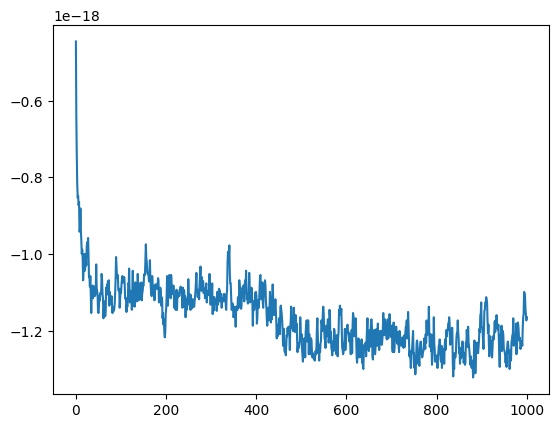

In [51]:
energies, sum_S_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(32, 50 * 1.380649e-23, 0, 1/(100* k_B), 0, 1000, 1)

plt.plot(np.linspace(0,1000,1000), energies)
plt.show()

C:\Users\fried\AppData\Local\Temp\ipykernel_28828\452003880.py:127: RuntimeWarning: invalid value encountered in scalar power
  return N_S * ((1 + z**2)**(1/4) * (1 - 6*z**2 + z**4))**(1/8) / np.sqrt(1 - z**2)


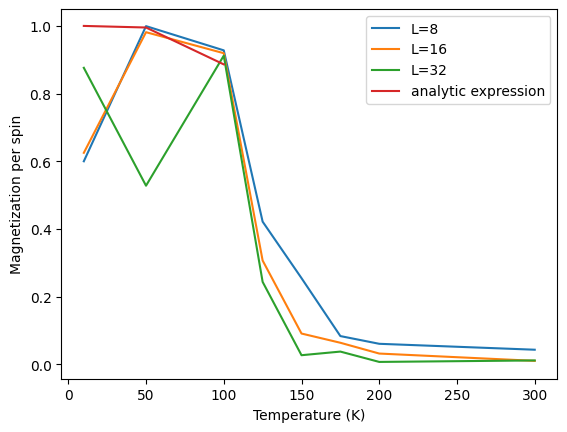

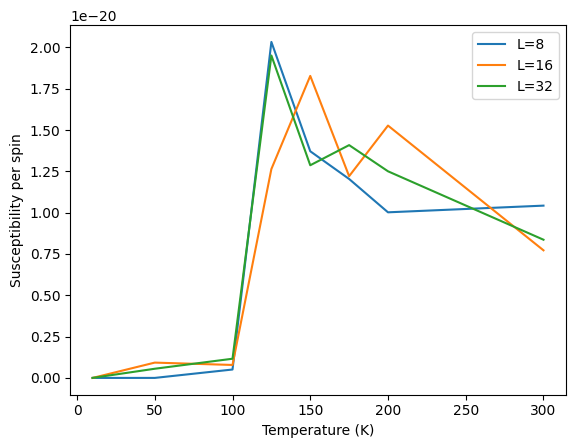

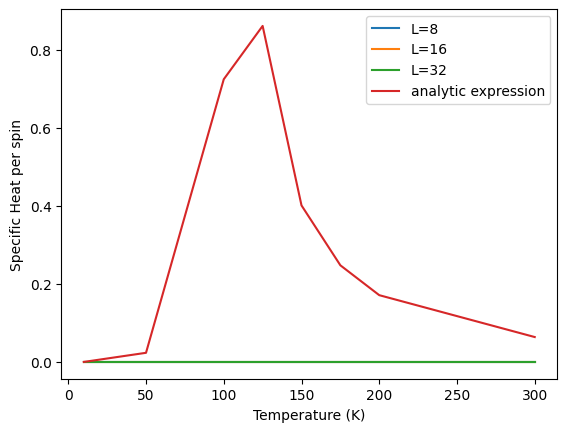

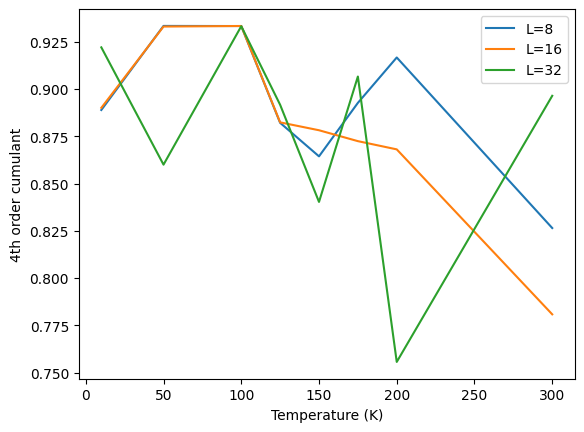

In [60]:
N = np.array([8, 16, 32])
k_B = 1.380649e-23
J = 50 * k_B
B = 0
T_array = [10, 50, 100, 125, 150, 175, 200, 300]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

for n in N:
    order_list, susc_list, spec_heat_list, cumulant_list = [], [], [], []
    for T in T_array:
        order_average, susc_average, spec_heat_average, cumulant = average_MCS(n, 5, J, B, T, k_B, 40, 20, 5) 
        order_list.append(order_average)
        susc_list.append(susc_average)
        spec_heat_list.append(spec_heat_average)
        cumulant_list.append(cumulant)
        
    
    ax1.plot(T_array, order_list/(n**2), label=f'L={n}')
    ax2.plot(T_array, susc_list/(n**2), label=f'L={n}')
    ax3.plot(T_array, spec_heat_list/(n**2), label=f'L={n}')
    ax4.plot(T_array, cumulant_list, label=f'L={n}')

order_exact = [abs_magnetization_exact(J/(k_B * T), 1) for T in T_array]
ax1.plot(T_array, order_exact, label='analytic expression')
spec_heat_exact = [specific_heat_exact(J/(k_B * T), 1) for T in T_array]
ax3.plot(T_array, spec_heat_exact, label='analytic expression')

# Magnetization plot
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Magnetization per spin')
ax1.legend()

# Susceptibility plot
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Susceptibility per spin')
ax2.legend()

# Specific Heat plot
ax3.set_xlabel('Temperature (K)')
ax3.set_ylabel('Specific Heat per spin')
ax3.legend()

# Cumulant plot
ax4.set_xlabel('Temperature (K)')
ax4.set_ylabel('4th order cumulant')
ax4.legend()